# REFERENCES:

https://www.kaggle.com/code/rimmelasghar/getting-started-with-image-preprocessing-in-python

I used this website to guide my preprocessing steps, including resizing all images to the same size and normalising pixel values before training. This helped ensure my model received consistent and clean input data.

https://medium.com/@kaanerdenn/convolutional-neural-network-cnn-computer-vision-75f17400b261

I used this website to structure my own preprocessing pipeline. In my project, I resized all images to 224×224 so they matched the input requirements of both my custom CNN and MobileNetV2. I normalised pixel values for the custom CNN using simple rescaling and used MobileNetV2’s preprocess_input function for transfer learning, as recommended for pretrained models. Although the website discusses augmentation and grayscale conversion, I decided not to apply these because my dataset already contained colour information and I wanted to avoid overfitting on a small dataset.

https://www.kaggle.com/code/nadaahassan/transfer-learning-with-mobilenetv2

https://keras.io/guides/transfer_learning/

I implemented transfer learning with help from this website.
I learned to use a two-stage approach: first freezing the MobileNetV2 base model to preserve pre-trained features, then unfreezing the top layers for fine-tuning with a small learning rate (1e-5).
I applied this methodology because my dataset is small (322 training images) and the guide explains this approach prevents overfitting while using ImageNet's learned features.

https://www.w3schools.com/python/python_ml_confusion_matrix.asp

https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

I used these 2 websites ro help when i was doing the confusion matrix and classification reports. They also helped when i did the evaluations.

I used the module material to help with this project aswell specifically week 3,4,5 and 6.

https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting





# **01_Preprocessing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
dataset_path= '/content/drive/MyDrive/RPS-AICoursework/Dataset'
print("Checking dataset folders...")

# Dataset verification step
# - Done to ensure dataset integrity before training
# - This confirms all class folders exist and are correctly named
# - Verifies class balance (important to avoid biased models)

for folder in ['None','Paper', 'Rock', 'Scissors']:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.exists(folder_path):
        count = len(os.listdir(folder_path))
        print(f"[OK] {folder}: {count} images")
    else:
        print(f"[ERROR] {folder}: NOT FOUND")


print("Dataset verification complete!")

Checking dataset folders...
[OK] None: 115 images
[OK] Paper: 115 images
[OK] Rock: 115 images
[OK] Scissors: 115 images
Dataset verification complete!


In [3]:
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install pandas

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [5]:
# IMG_SIZE = 224 is chosen because it is the standard input size for many pre-trained CNN architectures such as MobileNetV2.
# Using this size ensures compatibility between the custom CNN and the transfer learning model.
# Batch size of 32 provides a good balance between training stability, convergence speed, and GPU memory usage.

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
DATASET_PATH='/content/drive/MyDrive/RPS-AICoursework/Dataset'
CLASS_NAMES = ['None', 'Paper', 'Rock', 'Scissors']
NUM_CLASSES = len(CLASS_NAMES)

print("PROJECT CONFIGURATION")
print("=" * 50)
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Image shape: {IMG_SHAPE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")
print(f"Dataset path: {DATASET_PATH}")

PROJECT CONFIGURATION
Image size: 224x224
Image shape: (224, 224, 3)
Batch size: 32
Number of classes: 4
Classes: ['None', 'Paper', 'Rock', 'Scissors']
Dataset path: /content/drive/MyDrive/RPS-AICoursework/Dataset


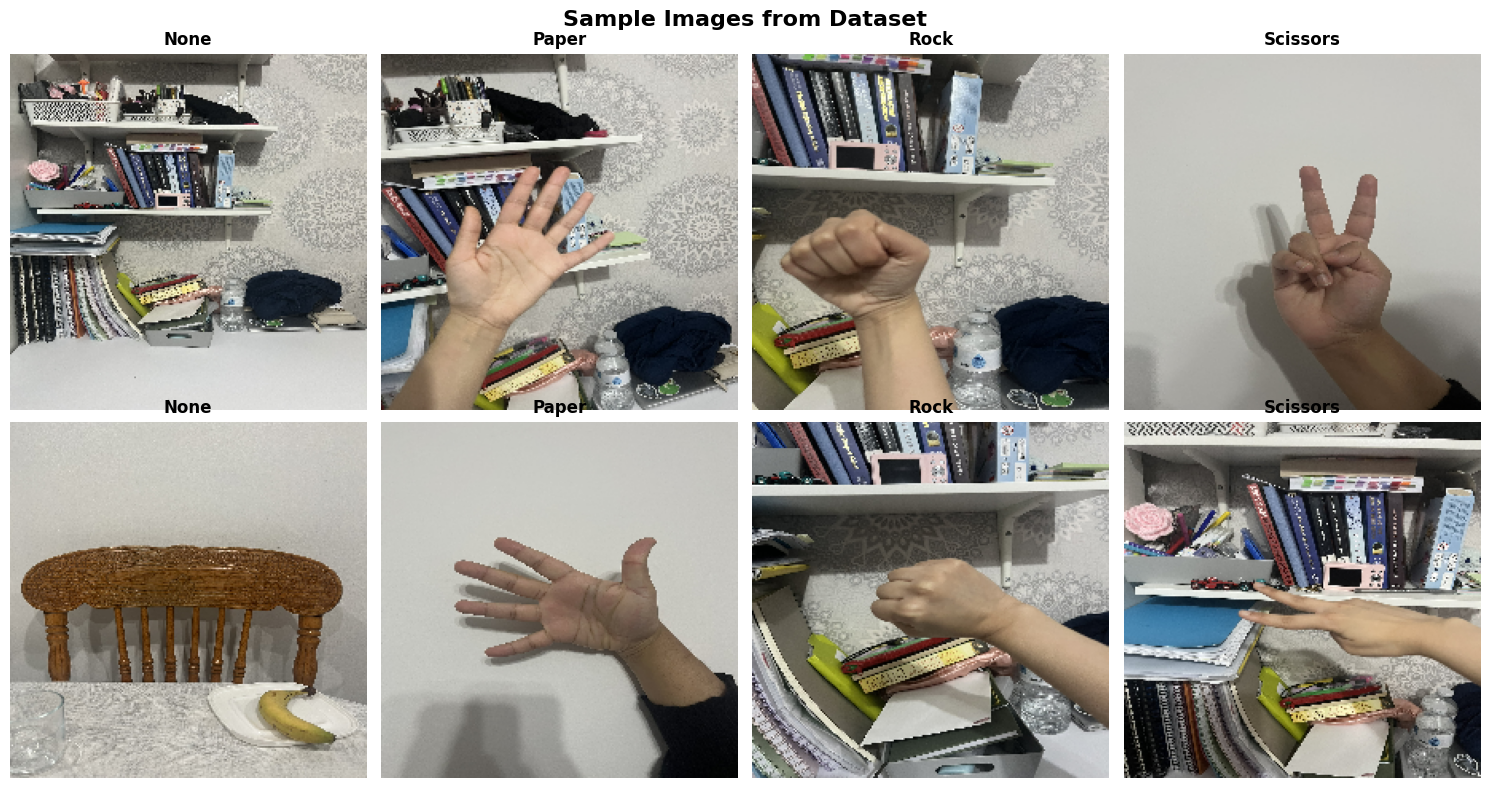


 Sample images displayed successfully!


In [6]:
# VISUALIZING SAMPLE IMAGES
# ============================================
# displaying 2 random images from each class to verify dataset quality
# helps me see what the images look like before training
# all images are resized to 224x224 which is what the model will see

# creating a 2x4 grid for displaying images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

# going through each class
for idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)

    # Gets all image in this class folder
    images = os.listdir(class_path)

    # Picks 2 random images
    import random
    random_images = random.sample(images, 2)

    # displays both images for this class
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)

        # Loads image at target size (224x224)
        # This is what the model will see
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

        # Displays in grid
        ax = axes[i, idx]
        ax.imshow(img)
        ax.set_title(f"{class_name}", fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

print("\n Sample images displayed successfully!")

In [34]:

# DATA SPLITTING

# splitting the dataset into train (70%), validation (15%), and test (15%)
# we need different sets for training, checking during training, and final testing
# train = model learns from this
# validation = checks how well its doing during training, stops overfitting
# test = final check at the end (model never sees this during training)

print("Preparing data splits...")
print("=" * 50)


# getting all the image paths and their labels

image_paths = []  # storing all the file paths
labels = []       # storing which class each image belongs to (0,1,2,3)

# going through each class folder
for class_idx, class_name in enumerate(CLASS_NAMES):
    # class_name is the actual folder name
    #class_idx gives me the number (0=None, 1=Paper 2=Rock, 3=Scissors)

    # getting the path to the class folder
    class_path = os.path.join(DATASET_PATH, class_name)

    # going through all 115 images in this folder
    for img_name in os.listdir(class_path):
        # full path to the image file
        img_path = os.path.join(class_path, img_name)

        # adding to the lists
        image_paths.append(img_path)    # save the path
        labels.append(class_idx)         # save which class it is

# checking i got all 460 images
print(f"Total images loaded: {len(image_paths)}")
print(f"Total labels: {len(labels)}")

# counting images per class (should be 115 each)
label_counts = {}
for class_idx, class_name in enumerate(CLASS_NAMES):
    count = labels.count(class_idx)  # how many of this class
    label_counts[class_name] = count
    print(f"  {class_name}: {count} images")



# first split - separating 70% for training

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels,          # all my images and labels
    test_size=0.30,               # keeping 30% aside (138 images)
    random_state=42,              # so i get the same split every time
    stratify=labels               # keeps the classes balanced in both sets
)
# now i have 322 for training and 138 to split again


# second split - splitting the 30% into validation and test = 15% validation and 15% test

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,      # splitting the 138 images
    test_size=0.50,               # half and half = 69 each
    random_state=42,              # same random state
    stratify=temp_labels          # keep classes balanced
)
# now i have 69 validation and 69 test


# showing the results

print("Data split complete!")
print("=" * 50)
print(f"Training set:   {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"Validation set: {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"Test set:       {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")
print("=" * 50)

# checking the class distribution is balanced
print("\nClass distribution:")
for split_name, split_labels in [("Train", train_labels), ("Val", val_labels), ("Test", test_labels)]:
    print(f"\n{split_name}:")
    for class_idx, class_name in enumerate(CLASS_NAMES):
        count = split_labels.count(class_idx)  # counting each class in each set
        print(f"  {class_name}: {count}")

Preparing data splits...
Total images loaded: 460
Total labels: 460
  None: 115 images
  Paper: 115 images
  Rock: 115 images
  Scissors: 115 images
Data split complete!
Training set:   322 images (70.0%)
Validation set: 69 images (15.0%)
Test set:       69 images (15.0%)

Class distribution:

Train:
  None: 80
  Paper: 81
  Rock: 80
  Scissors: 81

Val:
  None: 17
  Paper: 17
  Rock: 18
  Scissors: 17

Test:
  None: 18
  Paper: 17
  Rock: 17
  Scissors: 17


In [8]:
# ============================================
# CREATING DATA GENERATORS
# ============================================
# using imagedatagenerator to load and preprocess images
# just normalizing pixel values to 0-1 range
# generators feed batches of images to the model during training

print("Creating data generators...")
print("=" * 50)

# creating dataframes from splits
# imagedatagenerator needs dataframes with 'filename' and 'class' columns
train_df = pd.DataFrame({
    'filename': train_paths,
    'class': [CLASS_NAMES[label] for label in train_labels]
})

val_df = pd.DataFrame({
    'filename': val_paths,
    'class': [CLASS_NAMES[label] for label in val_labels]
})

test_df = pd.DataFrame({
    'filename': test_paths,
    'class': [CLASS_NAMES[label] for label in test_labels]
})

# creating generator - only normalization
# rescale converts pixel values from 0-255 to 0-1
simple_datagen = ImageDataGenerator(rescale=1./255)

# training generator
train_generator = simple_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',                  # column with image paths
    y_col='class',                     # column with class names
    target_size=(IMG_SIZE, IMG_SIZE),  # resize all to 224x224
    batch_size=BATCH_SIZE,             # load 32 images at a time
    class_mode='categorical',          # one-hot encode labels
    shuffle=True                       # shuffle for better training
)

# validation generator
val_generator = simple_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                      # don't shuffle validation
)

# test generator
test_generator = simple_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                      # don't shuffle test
)

print("=" * 50)
print("Generators created successfully")
print(f"  - Training batches: {len(train_generator)}")
print(f"  - Validation batches: {len(val_generator)}")
print(f"  - Test batches: {len(test_generator)}")
print("=" * 50)

Creating data generators...
Found 322 validated image filenames belonging to 4 classes.
Found 69 validated image filenames belonging to 4 classes.
Found 69 validated image filenames belonging to 4 classes.
Generators created successfully
  - Training batches: 11
  - Validation batches: 3
  - Test batches: 3


# **02_Building CNN Model**

Building CNN model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture created


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

CNN architecture diagram saved to Results folder.


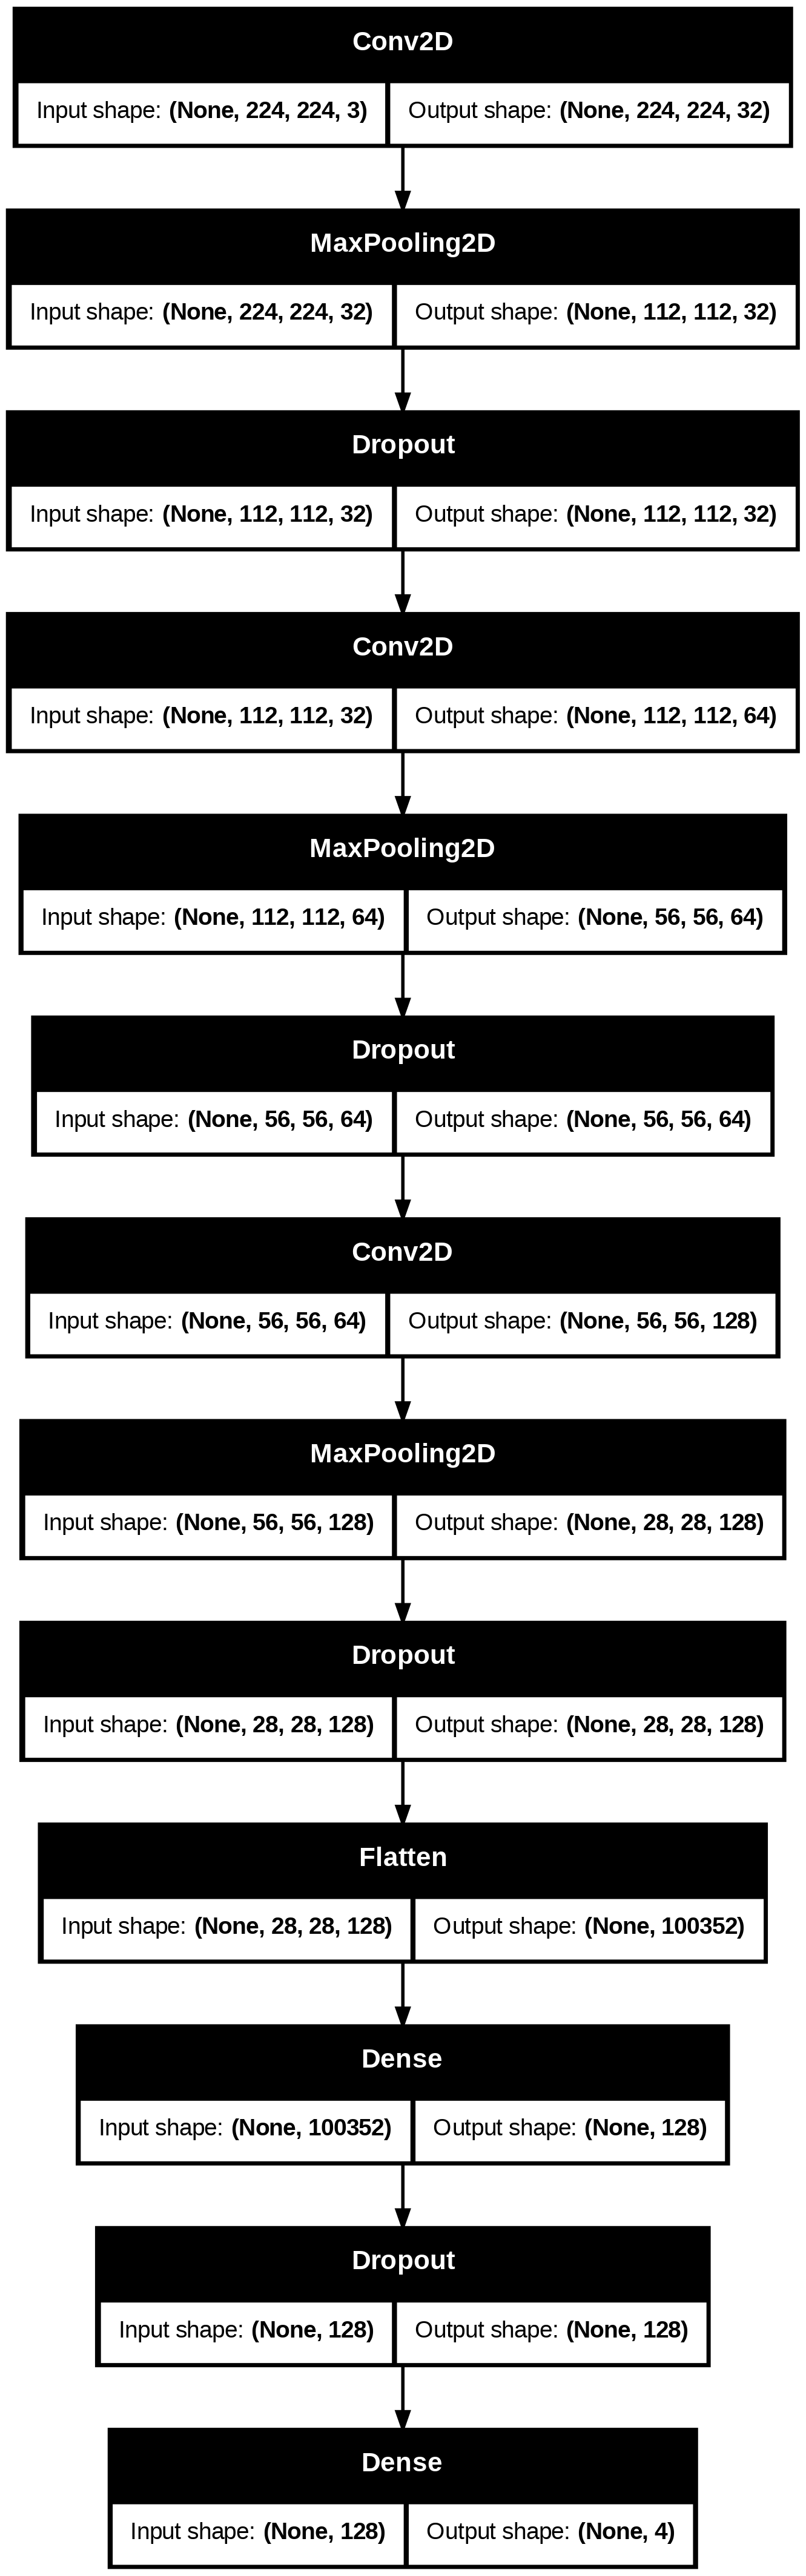

In [9]:
# ============================================
# BUILDING CNN MODEL
# ============================================
# creating a simple cnn architecture for hand gesture classification
# using week 6 concepts: convolutional blocks with pooling
# simple architecture works best for this small dataset (322 training images)
# architecture: 3 conv blocks → flatten → dense layers → output

from tensorflow.keras import models, layers


print("Building CNN model...")
print("=" * 50)

# Using Sequential API for CNN as it's a simple linear stack of layers
model = models.Sequential([

    # ===== BLOCK 1: 32 FILTERS =====
    # first conv layer learns basic features like edges and shapes
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=IMG_SHAPE),
    layers.MaxPooling2D((2, 2)),  # downsamples from 224x224 to 112x112
    layers.Dropout(0.25),         # dropout prevents overfitting (week 3)

    # ===== BLOCK 2: 64 FILTERS =====
    # second conv layer learns more complex patterns like finger positions
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),  # downsamples to 56x56
    layers.Dropout(0.25),

    # ===== BLOCK 3: 128 FILTERS =====
    # third conv layer learns high-level features specific to each gesture
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),  # downsamples to 28x28
    layers.Dropout(0.25),

    # ===== CLASSIFIER =====
    # flattening converts 2d feature maps to 1d vector
    layers.Flatten(),

    # dense layer combines features for final classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),          # higher dropout before output

    # output layer: 4 units for 4 classes, softmax for probabilities
    layers.Dense(NUM_CLASSES, activation='softmax')
])

print("=" * 50)
print("Model architecture created")
print("=" * 50)

# displaying model summary
model.summary()

tf.keras.utils.plot_model(
    model,
    to_file="/content/drive/MyDrive/RPS-AICoursework/Results/cnn_model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=200
)

print("CNN architecture diagram saved to Results folder.")

# visualizing model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
# ============================================
# COMPILING & TRAINING MODEL
# ============================================
# compiling: setting optimizer, loss function, and metrics
# training: fitting model on training data while monitoring validation

# compiling model
# adam optimizer - adaptive learning rate
# categorical_crossentropy - loss function for one-hot encoded labels
# accuracy - metric to track during training
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("=" * 50)
print("Starting training...")
print("=" * 50)

# training model
# epochs=20 - will make 20 complete passes through training data
# validation_data - monitors performance on unseen data during training
history = model.fit(
    train_generator,              # training data
    epochs=20,                    # number of complete passes
    validation_data=val_generator,  # validation data for monitoring
    verbose=1                     # show progress
)

model.save('/content/drive/MyDrive/RPS-AICoursework/Models/cnn_model.h5')


print("\n" + "=" * 50)
print("Training complete!")
print("=" * 50)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 177s 15s/step - accuracy: 0.2038 - loss: 5.4605 - val_accuracy: 0.2609 - val_loss: 1.3860
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2268 - loss: 1.3863 - val_accuracy: 0.3333 - val_loss: 1.3859
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2984 - loss: 1.3833 - val_accuracy: 0.3478 - val_loss: 1.3752
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3341 - loss: 1.3771 - val_accuracy: 0.5942 - val_loss: 1.3139
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4165 - loss: 1.2618 - val_accuracy: 0.6667 - val_loss: 0.9639
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5397 - loss: 0.9662 - val_accuracy: 0.6667 - val_loss: 0.7236
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6430 - loss: 0.8101 - val_accuracy: 0.7391 - val_loss: 0.7084
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6302 - loss: 0.8200 - val_accuracy: 0.7246 - val_los


Training complete!


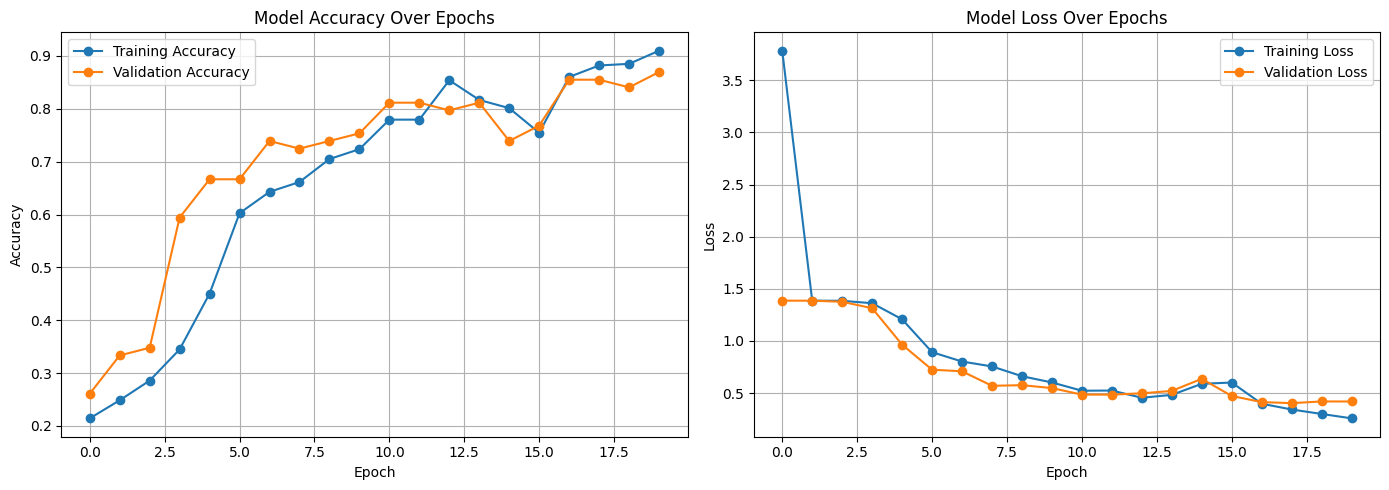

TRAINING SUMMARY
Best Validation Accuracy: 0.8696 at Epoch 20
Final Training Accuracy: 0.9099
Final Validation Accuracy: 0.8696


In [11]:
# ============================================
# PLOTTING TRAINING HISTORY
# ============================================

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss', marker='o')
plt.plot(history_df['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/cnn_training_accuracy_loss.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

# printing summary
print("=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)
print(f"Best Validation Accuracy: {history_df['val_accuracy'].max():.4f} at Epoch {history_df['val_accuracy'].idxmax() + 1}")
print(f"Final Training Accuracy: {history_df['accuracy'].iloc[-1]:.4f}")
print(f"Final Validation Accuracy: {history_df['val_accuracy'].iloc[-1]:.4f}")
print("=" * 50)

In [12]:
# ============================================
# EVALUATING ON TEST SET
# ============================================
# testing model on completely unseen test data
# this gives final performance metric - what the model will do in real use
# test set was never seen during training or validation

print("Evaluating model on test set...")
print("=" * 50)

# evaluating model
test_loss, test_accuracy = model.evaluate(test_generator)

# printing results
print("=" * 50)
print("TEST RESULTS")
print("=" * 50)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print("\nComparison:")
print(f"  Training Accuracy:   {history_df['accuracy'].iloc[-1]:.4f}")
print(f"  Validation Accuracy: {history_df['val_accuracy'].iloc[-1]:.4f}")
print(f"  Test Accuracy:       {test_accuracy:.4f}")
print("=" * 50)

Evaluating model on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8689 - loss: 0.3255
TEST RESULTS
Test Accuracy: 85.51%
Test Loss: 0.3495

Comparison:
  Training Accuracy:   0.9099
  Validation Accuracy: 0.8696
  Test Accuracy:       0.8551


Generating predictions and confusion matrix...
Processing 3 batches...
  Batch 1/3 processed
  Batch 2/3 processed
  Batch 3/3 processed
Total predictions: 69


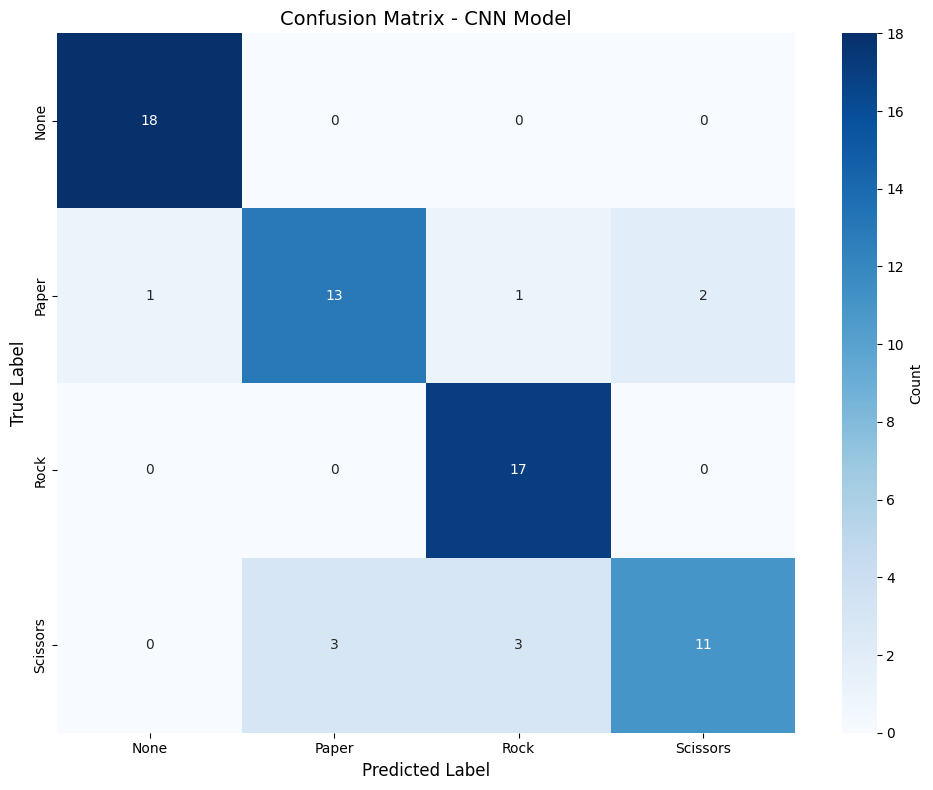


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        None       0.95      1.00      0.97        18
       Paper       0.81      0.76      0.79        17
        Rock       0.81      1.00      0.89        17
    Scissors       0.85      0.65      0.73        17

    accuracy                           0.86        69
   macro avg       0.85      0.85      0.85        69
weighted avg       0.86      0.86      0.85        69



In [13]:
# ============================================
# CONFUSION MATRIX & CLASSIFICATION REPORT
# ============================================
# confusion matrix shows which classes the model confuses
# classification report gives precision, recall, f1-score per class

print("Generating predictions and confusion matrix...")
print("=" * 50)

# RESET the test generator first
test_generator.reset()

# collecting true labels and predictions
y_true = []
y_pred = []

# calculate how many batches we need
num_batches = len(test_generator)

print(f"Processing {num_batches} batches...")

# STOP after processing all batches (so it doesn't loop infinitely)
for i in range(num_batches):
    images, labels = next(test_generator)
    predictions = model.predict(images, verbose=0)

    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

    print(f"  Batch {i+1}/{num_batches} processed")

print(f"Total predictions: {len(y_pred)}")

# generating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - CNN Model', fontsize=14)
plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/cnn_confusion_matrix.png",
    dpi=300,
    bbox_inches="tight"
)


plt.show()

# printing classification report
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
print("=" * 50)

# **03_Transfer Learning Model**

In [14]:
# ============================================
# BUILDING TRANSFER LEARNING MODEL
# ============================================
# using mobilenetv2 pre-trained on imagenet
# this will use the learned features and adapt them for our 4 classes
# MobileNetV2 was chosen because it is lightweight, efficient, and performs well on small datasets when used with transfer learning.


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Building Transfer Learning Model...")
print("=" * 50)

# ============================================
# LOAD PRE-TRAINED BASE MODEL
# ============================================
# mobilenetv2 was trained on imagenet
# it  has learned general features: edges, textures, shapes, objects

base_model = MobileNetV2(
    include_top=False,        # Remove original 1000-class classifier
    weights='imagenet',       # Use ImageNet pre-trained weights
    input_shape=IMG_SHAPE     # 224×224×3
)

# ============================================
# FREEZE BASE MODEL
# ============================================
# freeze = keep weights fixed during initial training
# will only train our custom classification head first

base_model.trainable = False

print(f"MobileNetV2 base model loaded")
print(f"  - Total layers: {len(base_model.layers)}")
print(f"  - Trainable: {base_model.trainable}")
print(f"  - Parameters: {base_model.count_params():,}")

# ============================================
# BUILD CUSTOM CLASSIFICATION HEAD
# ============================================
# lighter head (128 neurons) for small dataset (322 training images)

x = base_model.output
# Shape: (batch_size, 7, 7, 1280)

# GlobalAveragePooling: (7,7,1280) → (1280,)
x = GlobalAveragePooling2D()(x)

# Dense: 128 neurons (prevents overfitting on small dataset)
x = Dense(128, activation='relu')(x)

# Dropout: 50% regularization
x = Dropout(0.5)(x)

# Output: 4 classes with softmax
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# ============================================
# CREATE COMPLETE MODEL
# ============================================

transfer_model = Model(
    inputs=base_model.input,
    outputs=predictions
)

print("\nCustom head added (128 neurons)")
print("=" * 50)

# Model summary
transfer_model.summary()

# Save architecture diagram
tf.keras.utils.plot_model(
    transfer_model,
    to_file="/content/drive/MyDrive/RPS-AICoursework/Results/transfer_model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=200
)

print("Architecture diagram saved")
print("=" * 50)

Building Transfer Learning Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 base model loaded
  - Total layers: 154
  - Trainable: False
  - Parameters: 2,257,984

Custom head added (128 neurons)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Architecture diagram saved


In [15]:
# ============================================
# CREATING TRANSFER LEARNING DATA GENERATORS
# ============================================
# mobilenetv2 requires its own preprocessing (NOT rescale=1./255)
# need to use preprocess_input for correct normalization

print("\nCreating transfer learning generators...")
print("=" * 50)

# Training generator
transfer_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # MobileNetV2 preprocessing
)

transfer_train_generator = transfer_train_datagen.flow_from_dataframe(
    dataframe=train_df,              # Using same split as CNN
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
transfer_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

transfer_val_generator = transfer_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test generator
transfer_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

transfer_test_generator = transfer_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Transfer learning generators created")
print("  - Using MobileNetV2 preprocess_input (NOT rescale)")
print(f"  - Training batches: {len(transfer_train_generator)}")
print(f"  - Validation batches: {len(transfer_val_generator)}")
print(f"  - Test batches: {len(transfer_test_generator)}")
print("=" * 50)


Creating transfer learning generators...
Found 322 validated image filenames belonging to 4 classes.
Found 69 validated image filenames belonging to 4 classes.
Found 69 validated image filenames belonging to 4 classes.
Transfer learning generators created
  - Using MobileNetV2 preprocess_input (NOT rescale)
  - Training batches: 11
  - Validation batches: 3
  - Test batches: 3


In [16]:
# ============================================
# COMPILING TRANSFER LEARNING MODEL
# ============================================
# setting optimizer, loss function, and metrics

print("\nCompiling transfer learning model...")
print("=" * 50)

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Loss: categorical_crossentropy")
print("  - Metrics: accuracy")
print("=" * 50)


Compiling transfer learning model...
Model compiled
  - Optimizer: Adam (lr=0.001)
  - Loss: categorical_crossentropy
  - Metrics: accuracy


In [17]:
# ============================================
# SETTING UP CALLBACKS
# ============================================
# preventing overfitting during training
# callbacks monitor training and make adjustments automatically

print("\nConfiguring training callbacks...")
print("=" * 50)

# EarlyStopping: stops training if validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',              # Watch validation loss
    patience=5,                      # Stop if no improvement for 5 epochs
    restore_best_weights=True,       # Restore weights from best epoch
    verbose=1
)

# ReduceLROnPlateau: reduces learning rate when training plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',              # Watch validation loss
    factor=0.5,                      # Reduce LR by half (0.001 → 0.0005)
    patience=3,                      # Wait 3 epochs before reducing
    min_lr=1e-7,                     # Don't go below this LR
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Callbacks configured:")
print("  - EarlyStopping (patience=5, restore_best_weights=True)")
print("  - ReduceLROnPlateau (patience=3, factor=0.5)")
print("=" * 50)


Configuring training callbacks...
Callbacks configured:
  - EarlyStopping (patience=5, restore_best_weights=True)
  - ReduceLROnPlateau (patience=3, factor=0.5)


In [18]:
# ============================================
# TRAINING - (FROZEN BASE)
# ============================================
# training only the custom classification head (128 + 4 neurons)
# base model weights remain frozen (2.3M parameters not trained)
# this is fast and stops it from destroying the pre-trained features

print("\n" + "=" * 50)
print("TRAINING: Stage 1 - Frozen Base Model")
print("=" * 50)
print("Training only custom head (~164K parameters)")
print("Base model frozen (~2.3M parameters)")
print("\nStarting training...")

history_frozen = transfer_model.fit(
    transfer_train_generator,        # Using MobileNetV2 preprocessing
    epochs=15,                        # Max 15 (early stopping may end sooner)
    validation_data=transfer_val_generator,
    callbacks=callbacks,              # EarlyStopping + ReduceLR
    verbose=1
)

print("\n" + "=" * 50)
print("Training complete!")
print("=" * 50)

# Save model after frozen training
transfer_model.save('/content/drive/MyDrive/RPS-AICoursework/Models/transfer_model_frozen.h5')
print("Model saved: Models/transfer_model_frozen.h5")


TRAINING: Stage 1 - Frozen Base Model
Training only custom head (~164K parameters)
Base model frozen (~2.3M parameters)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.3895 - loss: 1.5993 - val_accuracy: 0.7391 - val_loss: 0.7126 - learning_rate: 0.0010
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6860 - loss: 0.7460 - val_accuracy: 0.8551 - val_loss: 0.4089 - learning_rate: 0.0010
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8502 - loss: 0.4328 - val_accuracy: 0.8986 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8754 - loss: 0.3360 - val_accuracy: 0.8841 - val_loss: 0.3299 - learning_rate: 0.0010
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9250 - loss: 0.2452 - val_accuracy: 0.9130 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9347 - loss: 0.2119 - val_accuracy: 0.9130 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 929ms/step - accuracy: 0.9295 - loss: 0.1849 - val_accurac


Training complete!
Model saved: Models/transfer_model_frozen.h5


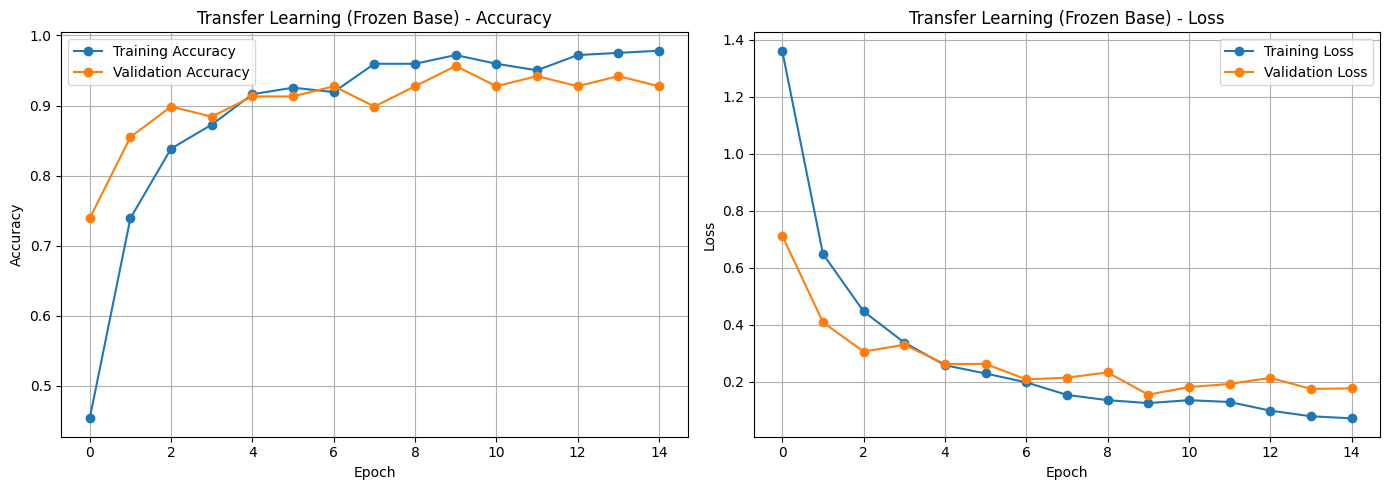

TRAINING SUMMARY (Frozen Base)
Epochs trained: 15
Best Val Accuracy: 0.9565 (Epoch 10)
Final Train Accuracy: 0.9783
Final Val Accuracy: 0.9275


In [19]:
# ============================================
# PLOTTING TRAINING HISTORY (FROZEN STAGE)
# ============================================

history_frozen_df = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_frozen_df['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_frozen_df['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Transfer Learning (Frozen Base) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_frozen_df['loss'], label='Training Loss', marker='o')
plt.plot(history_frozen_df['val_loss'], label='Validation Loss', marker='o')
plt.title('Transfer Learning (Frozen Base) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save plot
plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/transfer_training_accuracy_loss.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

print("=" * 50)
print("TRAINING SUMMARY (Frozen Base)")
print("=" * 50)
print(f"Epochs trained: {len(history_frozen_df)}")
print(f"Best Val Accuracy: {history_frozen_df['val_accuracy'].max():.4f} (Epoch {history_frozen_df['val_accuracy'].idxmax() + 1})")
print(f"Final Train Accuracy: {history_frozen_df['accuracy'].iloc[-1]:.4f}")
print(f"Final Val Accuracy: {history_frozen_df['val_accuracy'].iloc[-1]:.4f}")
print("=" * 50)

In [20]:
# ============================================
# EVALUATING ON TEST SET
# ============================================
# testing on completely unseen test data (69 images)
# this gives final real-world performance metric

print("\nEvaluating transfer learning model on test set...")
print("=" * 50)

transfer_test_loss, transfer_test_accuracy = transfer_model.evaluate(transfer_test_generator)

print("=" * 50)
print("TRANSFER LEARNING TEST RESULTS")
print("=" * 50)
print(f"Test Accuracy: {transfer_test_accuracy*100:.2f}%")
print(f"Test Loss: {transfer_test_loss:.4f}")
print("\nComparison:")
print(f"  Training Accuracy:   {history_frozen_df['accuracy'].iloc[-1]:.4f}")
print(f"  Validation Accuracy: {history_frozen_df['val_accuracy'].iloc[-1]:.4f}")
print(f"  Test Accuracy:       {transfer_test_accuracy:.4f}")
print("=" * 50)


Evaluating transfer learning model on test set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - accuracy: 0.9699 - loss: 0.1120
TRANSFER LEARNING TEST RESULTS
Test Accuracy: 97.10%
Test Loss: 0.1179

Comparison:
  Training Accuracy:   0.9783
  Validation Accuracy: 0.9275
  Test Accuracy:       0.9710



Generating confusion matrix...
  Batch 1/3 processed
  Batch 2/3 processed
  Batch 3/3 processed
Total predictions: 69


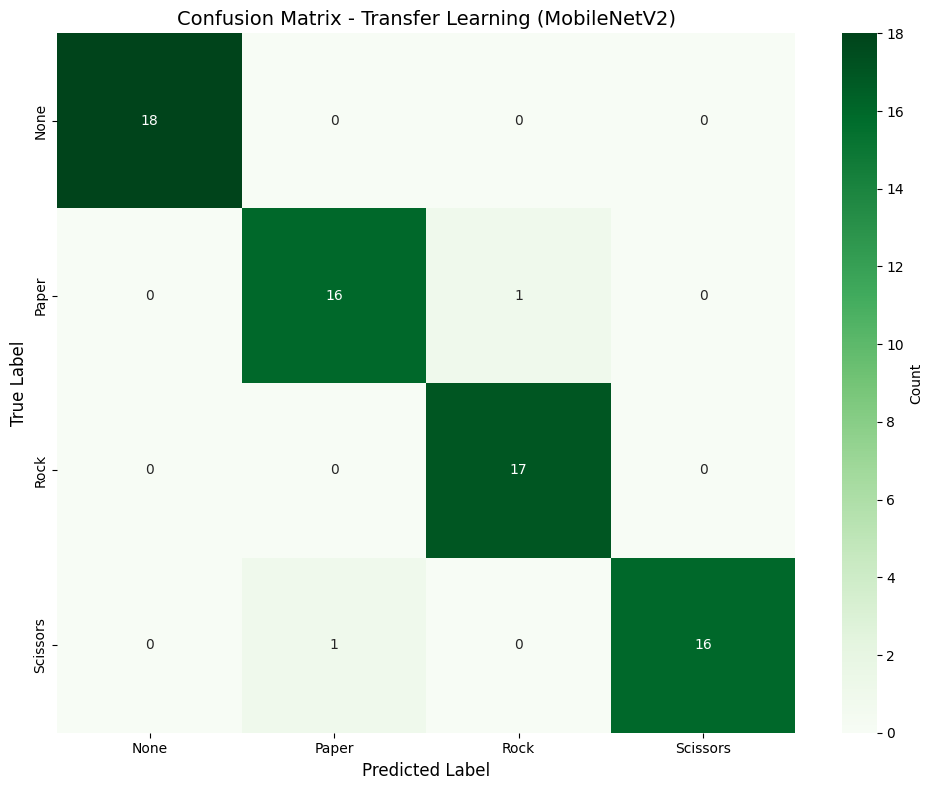


CLASSIFICATION REPORT - TRANSFER LEARNING
              precision    recall  f1-score   support

        None       1.00      1.00      1.00        18
       Paper       0.94      0.94      0.94        17
        Rock       0.94      1.00      0.97        17
    Scissors       1.00      0.94      0.97        17

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



In [21]:
# ============================================
# CONFUSION MATRIX - TRANSFER LEARNING
# ============================================
# shows which classes the model confuses with each other

print("\nGenerating confusion matrix...")
print("=" * 50)

# Reset generator
transfer_test_generator.reset()

# Collect predictions
transfer_y_true = []
transfer_y_pred = []

num_batches = len(transfer_test_generator)

for i in range(num_batches):
    images, labels = next(transfer_test_generator)
    predictions = transfer_model.predict(images, verbose=0)

    transfer_y_true.extend(np.argmax(labels, axis=1))
    transfer_y_pred.extend(np.argmax(predictions, axis=1))

    print(f"  Batch {i+1}/{num_batches} processed")

print(f"Total predictions: {len(transfer_y_pred)}")

# Generate confusion matrix
transfer_cm = confusion_matrix(transfer_y_true, transfer_y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(transfer_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Transfer Learning (MobileNetV2)', fontsize=14)
plt.tight_layout()

# Save confusion matrix
plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/transfer_confusion_matrix.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

# Print classification report
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT - TRANSFER LEARNING")
print("=" * 50)
print(classification_report(transfer_y_true, transfer_y_pred, target_names=CLASS_NAMES))
print("=" * 50)

In [22]:
# ============================================
# MODEL COMPARISON: CNN vs TRANSFER LEARNING
# ============================================

print("\n" + "=" * 50)
print("COMPARING BOTH MODELS")
print("=" * 50)

comparison_data = {
    'Metric': [
        'Test Accuracy',
        'Test Loss',
        'Total Parameters',
        'Trainable Parameters',
        'Architecture'
    ],
    'Custom CNN': [
        f"{test_accuracy:.4f}",
        f"{test_loss:.4f}",
        f"{model.count_params():,}",
        f"{model.count_params():,}",
        '3 Conv Blocks'
    ],
    'Transfer Learning': [
        f"{transfer_test_accuracy:.4f}",
        f"{transfer_test_loss:.4f}",
        f"{transfer_model.count_params():,}",
        f"{sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights]):,}",
        'MobileNetV2 + Custom Head'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('/content/drive/MyDrive/RPS-AICoursework/Results/model_comparison.csv', index=False)
print("\n Comparison saved: Results/model_comparison.csv")

# Determine winner
if transfer_test_accuracy > test_accuracy:
    improvement = (transfer_test_accuracy - test_accuracy) * 100
    print(f"\n Transfer Learning performs better by {improvement:.2f}%")
else:
    improvement = (test_accuracy - transfer_test_accuracy) * 100
    print(f"\n Custom CNN performs better by {improvement:.2f}%")

print("=" * 50)


COMPARING BOTH MODELS


              Metric    Custom CNN         Transfer Learning
       Test Accuracy        0.8551                    0.9710
           Test Loss        0.3495                    0.1179
    Total Parameters    12,938,948                 2,422,468
Trainable Parameters    12,938,948                   164,484
        Architecture 3 Conv Blocks MobileNetV2 + Custom Head

 Comparison saved: Results/model_comparison.csv

 Transfer Learning performs better by 11.59%


# **04_Transfer Learning – Fine-Tuning**

In this stage, selected upper layers of the pre-trained MobileNetV2 base model are unfrozen and fine-tuned on the custom Rock–Paper–Scissors dataset.  
A very small learning rate is used to refine high-level features without destroying the general visual representations learned from ImageNet.

This improves classification performance and generalisation on cluttered backgrounds while reducing overfitting.


In [23]:
# ============================================
# FINE-TUNING TRANSFER LEARNING MODEL
# ============================================
# unfreeze the top layers of MobileNetV2 and continue training with a VERY small learning rate.
# This allows the model to adapt high-level ImageNet features specifically to hand gesture recognition.
# Freezing lower layers keeps the generic visual features, while fine-tuning only the top layers allows it to adaptat to hand gesture-specific patterns without overfitting.


print("\nStarting fine-tuning (Stage 2)...")
print("=" * 60)

# ============================================
# UNFREEZE TOP LAYERS OF BASE MODEL
# ============================================
# Dont need to unfreeze the entire base model.
# Early layers detect generic features (edges, textures)
# Later layers detect task-specific patterns (hands, shapes)

# Number of layers to unfreeze from the top
FINE_TUNE_AT = int(len(base_model.layers) * 0.75)
# unfreeze top 25% of MobileNetV2 layers

for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False  # keep lower layers frozen

for layer in base_model.layers[FINE_TUNE_AT:]:
    layer.trainable = True   # fine-tune higher layers

print(f"Unfroze top {len(base_model.layers) - FINE_TUNE_AT} layers")
print(f"Frozen layers: {FINE_TUNE_AT}")
print("=" * 60)

# ============================================
# RE-COMPILE MODEL WITH SMALL LR
# ============================================
# Need to recompile after changing trainable layers
# Small learning rate prevents destroying pretrained weights

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # very small learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled for fine-tuning")
print("  - Optimizer: Adam")
print("  - Learning rate: 1e-5 (safe for fine-tuning)")
print("=" * 60)

# ============================================
# FINE-TUNING TRAINING
# ============================================
# Need to train for a small number of epochs
# EarlyStopping ensures it doesn't overfit

history_finetuned = transfer_model.fit(
    transfer_train_generator,
    epochs=10,                          # fine-tuning requires fewer epochs
    validation_data=transfer_val_generator,
    callbacks=callbacks,                # same callbacks as before
    verbose=1
)

print("\n Fine-tuning complete!")
print("=" * 60)

# Save fine tuned model

transfer_model.save(
    "/content/drive/MyDrive/RPS-AICoursework/Models/transfer_model_finetuned.h5"
)

print("Fine-tuned model saved:")
print("  Models/transfer_model_finetuned.h5")
print("=" * 60)



Starting fine-tuning (Stage 2)...
Unfroze top 39 layers
Frozen layers: 115
Model recompiled for fine-tuning
  - Optimizer: Adam
  - Learning rate: 1e-5 (safe for fine-tuning)
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8839 - loss: 0.3748 - val_accuracy: 0.9710 - val_loss: 0.1456 - learning_rate: 1.0000e-05
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9299 - loss: 0.2705 - val_accuracy: 0.9855 - val_loss: 0.1438 - learning_rate: 1.0000e-05
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9508 - loss: 0.2103 - val_accuracy: 0.9855 - val_loss: 0.1421 - learning_rate: 1.0000e-05
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9461 - loss: 0.2044 - val_accuracy: 0.9855 - val_loss: 0.1402 - learning_rate: 1.0000e-05
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9584 - loss: 0.1789 - val_accuracy: 0.9855 - val_loss: 0.1390 - learning_rate: 1.0000e-05
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - ac


 Fine-tuning complete!
Fine-tuned model saved:
  Models/transfer_model_finetuned.h5


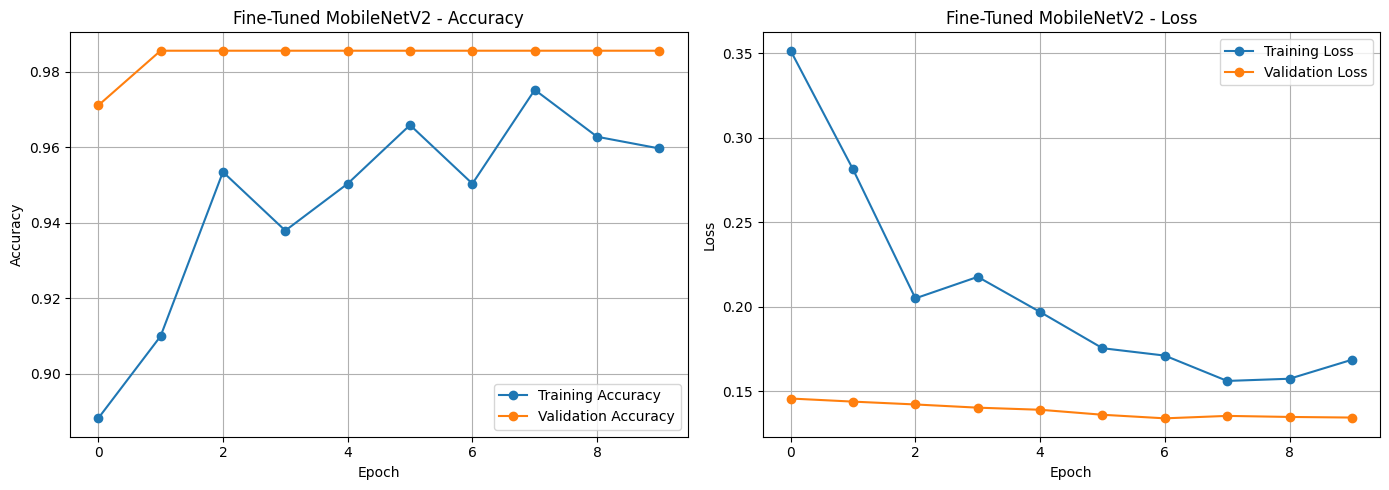

TRAINING SUMMARY (Fine-Tuned MobileNetV2)
Epochs trained: 10
Best Val Accuracy: 0.9855 (Epoch 2)
Best Val Loss:     0.1339 (Epoch 7)
Final Train Accuracy: 0.9596
Final Val Accuracy:   0.9855
Final Train Loss:     0.1686
Final Val Loss:       0.1344


In [24]:
# ============================================
# PLOTTING TRAINING HISTORY (FINE-TUNED MODEL)
# ============================================

history_finetuned_df = pd.DataFrame(history_finetuned.history)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetuned_df['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_finetuned_df['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Fine-Tuned MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetuned_df['loss'], label='Training Loss', marker='o')
plt.plot(history_finetuned_df['val_loss'], label='Validation Loss', marker='o')
plt.title('Fine-Tuned MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

best_val_acc = history_finetuned_df['val_accuracy'].max()
best_val_acc_epoch = history_finetuned_df['val_accuracy'].idxmax() + 1

best_val_loss = history_finetuned_df['val_loss'].min()
best_val_loss_epoch = history_finetuned_df['val_loss'].idxmin() + 1


# SAVE
plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/finetuned_training_accuracy_loss.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

#Training Summary

print("=" * 50)
print("TRAINING SUMMARY (Fine-Tuned MobileNetV2)")
print("=" * 50)

print(f"Epochs trained: {len(history_finetuned_df)}")
print(f"Best Val Accuracy: {best_val_acc:.4f} (Epoch {best_val_acc_epoch})")
print(f"Best Val Loss:     {best_val_loss:.4f} (Epoch {best_val_loss_epoch})")
print(f"Final Train Accuracy: {history_finetuned_df['accuracy'].iloc[-1]:.4f}")
print(f"Final Val Accuracy:   {history_finetuned_df['val_accuracy'].iloc[-1]:.4f}")
print(f"Final Train Loss:     {history_finetuned_df['loss'].iloc[-1]:.4f}")
print(f"Final Val Loss:       {history_finetuned_df['val_loss'].iloc[-1]:.4f}")
print("=" * 50)


In [25]:
# ============================================
# TESTING FINE-TUNED MODEL
# ============================================

print("\nEvaluating fine-tuned model on test set...")
print("=" * 50)

finetuned_test_loss, finetuned_test_accuracy = transfer_model.evaluate(
    transfer_test_generator
)

print("=" * 50)
print("FINE-TUNED MODEL TEST RESULTS")
print("=" * 50)
print(f"Test Accuracy: {finetuned_test_accuracy*100:.2f}%")
print(f"Test Loss: {finetuned_test_loss:.4f}")
print("=" * 50)



Evaluating fine-tuned model on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.9699 - loss: 0.1025
FINE-TUNED MODEL TEST RESULTS
Test Accuracy: 97.10%
Test Loss: 0.1102


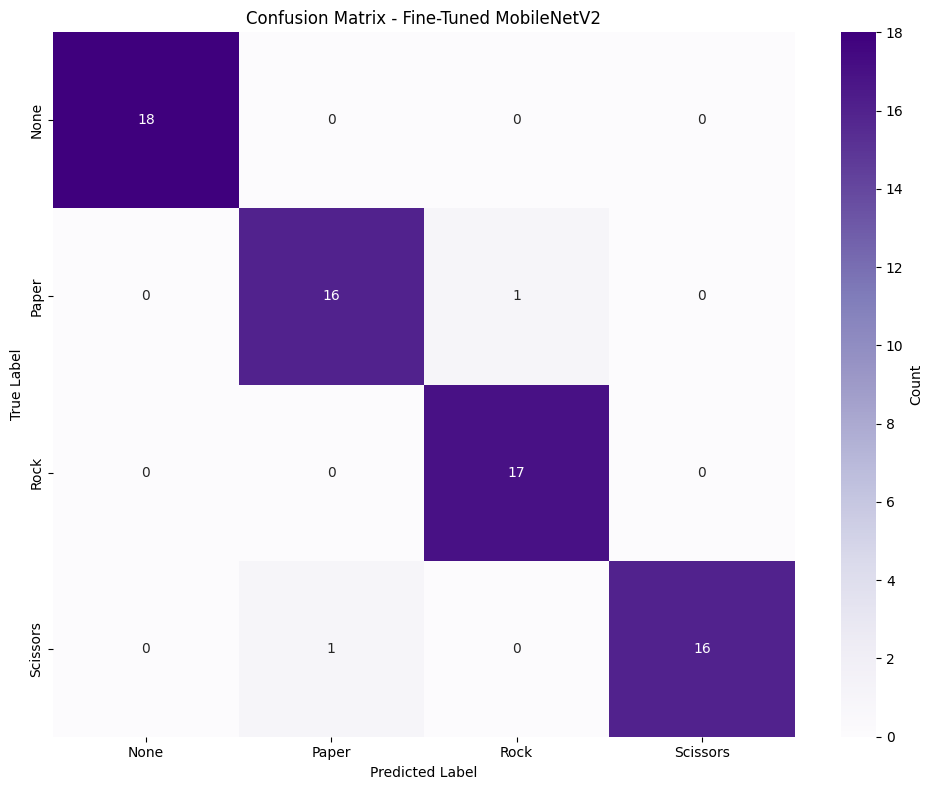


CLASSIFICATION REPORT - FINE-TUNED MODEL
              precision    recall  f1-score   support

        None       1.00      1.00      1.00        18
       Paper       0.94      0.94      0.94        17
        Rock       0.94      1.00      0.97        17
    Scissors       1.00      0.94      0.97        17

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



In [26]:
# ============================================
# CONFUSION MATRIX - FINE-TUNED MODEL
# ============================================

transfer_test_generator.reset()

finetuned_y_true = []
finetuned_y_pred = []

num_batches = len(transfer_test_generator)

for i in range(num_batches):
    images, labels = next(transfer_test_generator)
    predictions = transfer_model.predict(images, verbose=0)

    finetuned_y_true.extend(np.argmax(labels, axis=1))
    finetuned_y_pred.extend(np.argmax(predictions, axis=1))

# Confusion matrix
finetuned_cm = confusion_matrix(finetuned_y_true, finetuned_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    finetuned_cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Count'}
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fine-Tuned MobileNetV2')
plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/finetuned_confusion_matrix.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

print("\nCLASSIFICATION REPORT - FINE-TUNED MODEL")
print("=" * 50)
print(classification_report(finetuned_y_true, finetuned_y_pred, target_names=CLASS_NAMES))
print("=" * 50)


# 05_Evaluation




In [27]:
import pandas as pd

results_summary = pd.DataFrame([
    {
        "Model": "Custom CNN",
        "Test Accuracy": test_accuracy,
        "Test Loss": test_loss,
        "Notes": "Baseline CNN (trained from scratch)"
    },
    {
        "Model": "MobileNetV2 (Frozen)",
        "Test Accuracy": transfer_test_accuracy,
        "Test Loss": transfer_test_loss,
        "Notes": "Transfer learning (base frozen)"
    },
    {
        "Model": "MobileNetV2 (Fine-tuned)",
        "Test Accuracy": finetuned_test_accuracy,
        "Test Loss": finetuned_test_loss,
        "Notes": "Fine-tuned top layers"
    }
])

print(results_summary)

results_summary.to_csv(
    "/content/drive/MyDrive/RPS-AICoursework/Results/results_summary.csv",
    index=False
)
print("Saved: Results/results_summary.csv")


                      Model  Test Accuracy  Test Loss  \
0                Custom CNN       0.855072   0.349515   
1      MobileNetV2 (Frozen)       0.971014   0.117894   
2  MobileNetV2 (Fine-tuned)       0.971014   0.110193   

                                 Notes  
0  Baseline CNN (trained from scratch)  
1      Transfer learning (base frozen)  
2                Fine-tuned top layers  
Saved: Results/results_summary.csv


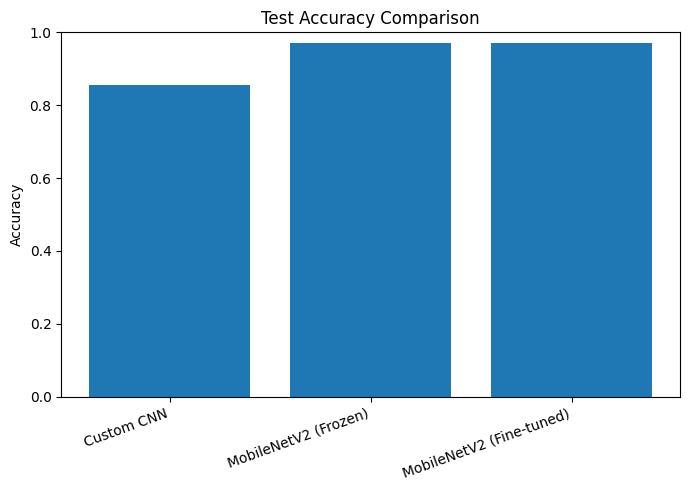

Saved: Results/test_accuracy_comparison.png


In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(results_summary["Model"], results_summary["Test Accuracy"])
plt.ylim(0, 1)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

plt.savefig(
    "/content/drive/MyDrive/RPS-AICoursework/Results/test_accuracy_comparison.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
print("Saved: Results/test_accuracy_comparison.png")


In [29]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Load both saved models
frozen_model = load_model("/content/drive/MyDrive/RPS-AICoursework/Models/transfer_model_frozen.h5")
finetuned_model = load_model("/content/drive/MyDrive/RPS-AICoursework/Models/transfer_model_finetuned.h5")

def eval_model(model_to_test, generator, name):
    generator.reset()
    y_true, y_pred = [], []

    for _ in range(len(generator)):
        x, y = next(generator)
        p = model_to_test.predict(x, verbose=0)
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(p, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{name} accuracy:", np.mean(np.array(y_true)==np.array(y_pred)))
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    return cm

cm_frozen = eval_model(frozen_model, transfer_test_generator, "Frozen MobileNetV2")
cm_finetuned = eval_model(finetuned_model, transfer_test_generator, "Fine-tuned MobileNetV2")

print("\nDifference between confusion matrices:")
print(cm_finetuned - cm_frozen)



Frozen MobileNetV2 accuracy: 0.9710144927536232
              precision    recall  f1-score   support

        None       1.00      1.00      1.00        18
       Paper       0.94      0.94      0.94        17
        Rock       0.94      1.00      0.97        17
    Scissors       1.00      0.94      0.97        17

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69


Fine-tuned MobileNetV2 accuracy: 0.9710144927536232
              precision    recall  f1-score   support

        None       1.00      1.00      1.00        18
       Paper       0.94      0.94      0.94        17
        Rock       0.94      1.00      0.97        17
    Scissors       1.00      0.94      0.97        17

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69


Difference between confusio

In [30]:
# ============================================
# FINAL RESULTS SUMMARY (ALL MODELS)
# ============================================

results_detailed = pd.DataFrame([
    {
        "Model": "Custom CNN",
        "Best Val Accuracy": history_df['val_accuracy'].max(),
        "Best Val Loss": history_df['val_loss'].min(),
        "Final Train Accuracy": history_df['accuracy'].iloc[-1],
        "Final Val Accuracy": history_df['val_accuracy'].iloc[-1],
        "Test Accuracy": test_accuracy,
        "Test Loss": test_loss
    },
    {
        "Model": "MobileNetV2 (Frozen)",
        "Best Val Accuracy": history_frozen_df['val_accuracy'].max(),
        "Best Val Loss": history_frozen_df['val_loss'].min(),
        "Final Train Accuracy": history_frozen_df['accuracy'].iloc[-1],
        "Final Val Accuracy": history_frozen_df['val_accuracy'].iloc[-1],
        "Test Accuracy": transfer_test_accuracy,
        "Test Loss": transfer_test_loss
    },
    {
        "Model": "MobileNetV2 (Fine-Tuned)",
        "Best Val Accuracy": history_finetuned_df['val_accuracy'].max(),
        "Best Val Loss": history_finetuned_df['val_loss'].min(),
        "Final Train Accuracy": history_finetuned_df['accuracy'].iloc[-1],
        "Final Val Accuracy": history_finetuned_df['val_accuracy'].iloc[-1],
        "Test Accuracy": finetuned_test_accuracy,
        "Test Loss": finetuned_test_loss
    }
])

# Display
print("\nFINAL MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_detailed.round(4).to_string(index=False))
print("=" * 60)

# Save to CSV
results_detailed.to_csv(
    "/content/drive/MyDrive/RPS-AICoursework/Results/final_results_summary.csv",
    index=False
)

print("Saved: Results/final_results_summary.csv")



FINAL MODEL COMPARISON SUMMARY
                   Model  Best Val Accuracy  Best Val Loss  Final Train Accuracy  Final Val Accuracy  Test Accuracy  Test Loss
              Custom CNN             0.8696         0.4027                0.9099              0.8696         0.8551     0.3495
    MobileNetV2 (Frozen)             0.9565         0.1549                0.9783              0.9275         0.9710     0.1179
MobileNetV2 (Fine-Tuned)             0.9855         0.1339                0.9596              0.9855         0.9710     0.1102
Saved: Results/final_results_summary.csv


In [31]:
# ============================================
# OVERFITTING/UNDERFITTING ANALYSIS
# ============================================
# analysing the gap between training and test performance
# helps identify if model is memorizing (overfitting) or too simple (underfitting)

print("=" * 60)
print("OVERFITTING/UNDERFITTING ANALYSIS")
print("=" * 60)

def analyze_overfitting(train_acc, val_acc, test_acc, model_name):
    """
    Analyzes overfitting by comparing training vs test accuracy

    Parameters:
    - train_acc: final training accuracy
    - val_acc: final validation accuracy
    - test_acc: test set accuracy
    - model_name: name of model for display

    Interpretation:
    - Small gap (<5%): Good generalization
    - Medium gap (5-10%): Acceptable, regularization working
    - Large gap (>15%): Overfitting, memorizing training data
    """

    # calculate the gap between training and test
    # large gap = overfitting (memorising the training data)
    gap = train_acc - test_acc

    print(f"\n{model_name}:")
    print(f"  Training Accuracy:   {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy:       {test_acc:.4f}")
    print(f"  Train-Test Gap:      {gap:.4f} ({gap*100:.2f}%)")

    # interpret the gap size
    # smaller gap = better generalisation
    if gap < 0.05:
        print("  Excellent generalization - minimal overfitting")
        print("    Model performs similarly on unseen data")
    elif gap < 0.10:
        print("  Slight overfitting - acceptable for this dataset size")
        print("    Dropout and regularisation are working")
    elif gap < 0.15:
        print("  Moderate overfitting - regularisation helping")
        print("    Could benefit from more dropout or data")
    else:
        print("  Significant overfitting detected")
        print("    Model memorizing training data, needs stronger regularisation")

    # check for underfitting
    # both train and val low = model too simple
    if train_acc < 0.75 and val_acc < 0.75:
        print("  Possible underfitting - model may be too simple")

    return gap

# analyse all three models
# comparing their generalisation performance

print("\n" + "=" * 60)
print("COMPARING GENERALISATION ACROSS ALL MODELS")
print("=" * 60)

# custom cnn analysis
cnn_gap = analyze_overfitting(
    history_df['accuracy'].iloc[-1],      # final training accuracy
    history_df['val_accuracy'].iloc[-1],  # final validation accuracy
    test_accuracy,                         # test set accuracy
    "Custom CNN"
)

# transfer learning (frozen) analysis
transfer_gap = analyze_overfitting(
    history_frozen_df['accuracy'].iloc[-1],
    history_frozen_df['val_accuracy'].iloc[-1],
    transfer_test_accuracy,
    "MobileNetV2 (Frozen)"
)

# transfer learning (fine-tuned) analysis
finetuned_gap = analyze_overfitting(
    history_finetuned_df['accuracy'].iloc[-1],
    history_finetuned_df['val_accuracy'].iloc[-1],
    finetuned_test_accuracy,
    "MobileNetV2 (Fine-Tuned)"
)

# summary comparison
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Custom CNN gap:          {cnn_gap*100:.2f}%")
print(f"Transfer (Frozen) gap:   {transfer_gap*100:.2f}%")
print(f"Transfer (Fine-tuned) gap: {finetuned_gap*100:.2f}%")

# identify best generaliser
gaps = {
    'Custom CNN': cnn_gap,
    'MobileNetV2 (Frozen)': transfer_gap,
    'MobileNetV2 (Fine-Tuned)': finetuned_gap
}
best_model = min(gaps, key=gaps.get)
print(f"\nBest generalization: {best_model}")
print(f"  (Smallest train-test gap = less overfitting)")
print("=" * 60)

OVERFITTING/UNDERFITTING ANALYSIS

COMPARING GENERALIZATION ACROSS ALL MODELS

Custom CNN:
  Training Accuracy:   0.9099
  Validation Accuracy: 0.8696
  Test Accuracy:       0.8551
  Train-Test Gap:      0.0549 (5.49%)
  Slight overfitting - acceptable for this dataset size
    Dropout and regularization are working

MobileNetV2 (Frozen):
  Training Accuracy:   0.9783
  Validation Accuracy: 0.9275
  Test Accuracy:       0.9710
  Train-Test Gap:      0.0072 (0.72%)
  Excellent generalization - minimal overfitting
    Model performs similarly on unseen data

MobileNetV2 (Fine-Tuned):
  Training Accuracy:   0.9596
  Validation Accuracy: 0.9855
  Test Accuracy:       0.9710
  Train-Test Gap:      -0.0114 (-1.14%)
  Excellent generalization - minimal overfitting
    Model performs similarly on unseen data

SUMMARY
Custom CNN gap:          5.49%
Transfer (Frozen) gap:   0.72%
Transfer (Fine-tuned) gap: -1.14%

Best generalization: MobileNetV2 (Fine-Tuned)
  (Smallest train-test gap = less ov

ERROR ANALYSIS: MISCLASSIFIED EXAMPLES

Custom CNN:
  Total misclassifications: 10
  Error rate: 14.49%

MobileNetV2 (Fine-Tuned):
  Total misclassifications: 2
  Error rate: 2.90%

MOST COMMON CONFUSION PATTERNS (CNN)

Top 5 confusion pairs:
  Scissors → Rock: 3 times
  Scissors → Paper: 3 times
    (Extended fingers can look similar)
  Paper → Scissors: 2 times
    (Extended fingers can look similar)
  Paper → None: 1 times
  Paper → Rock: 1 times
    (Likely due to similar hand positions in certain angles)

Generating misclassified examples visualization...


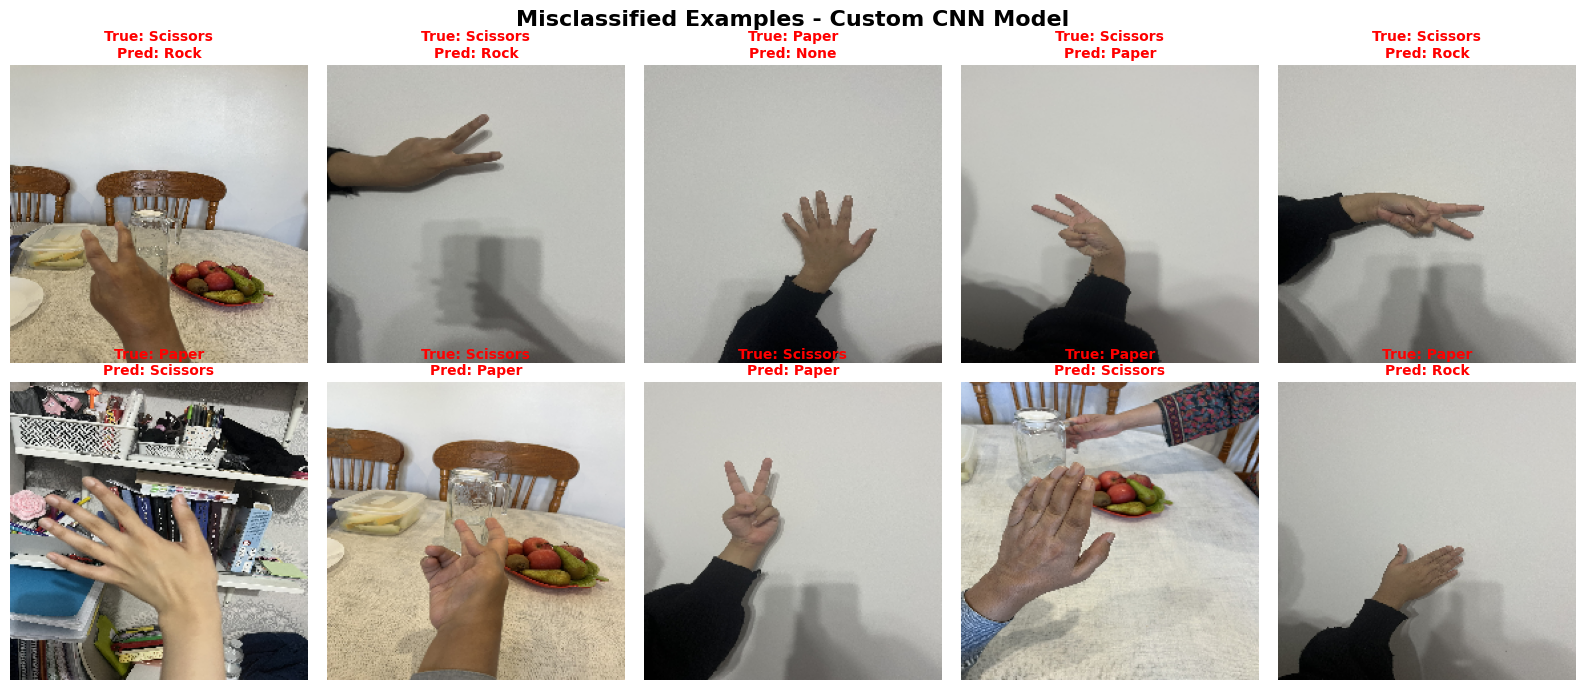


 Saved: Results/cnn_misclassified_examples.png


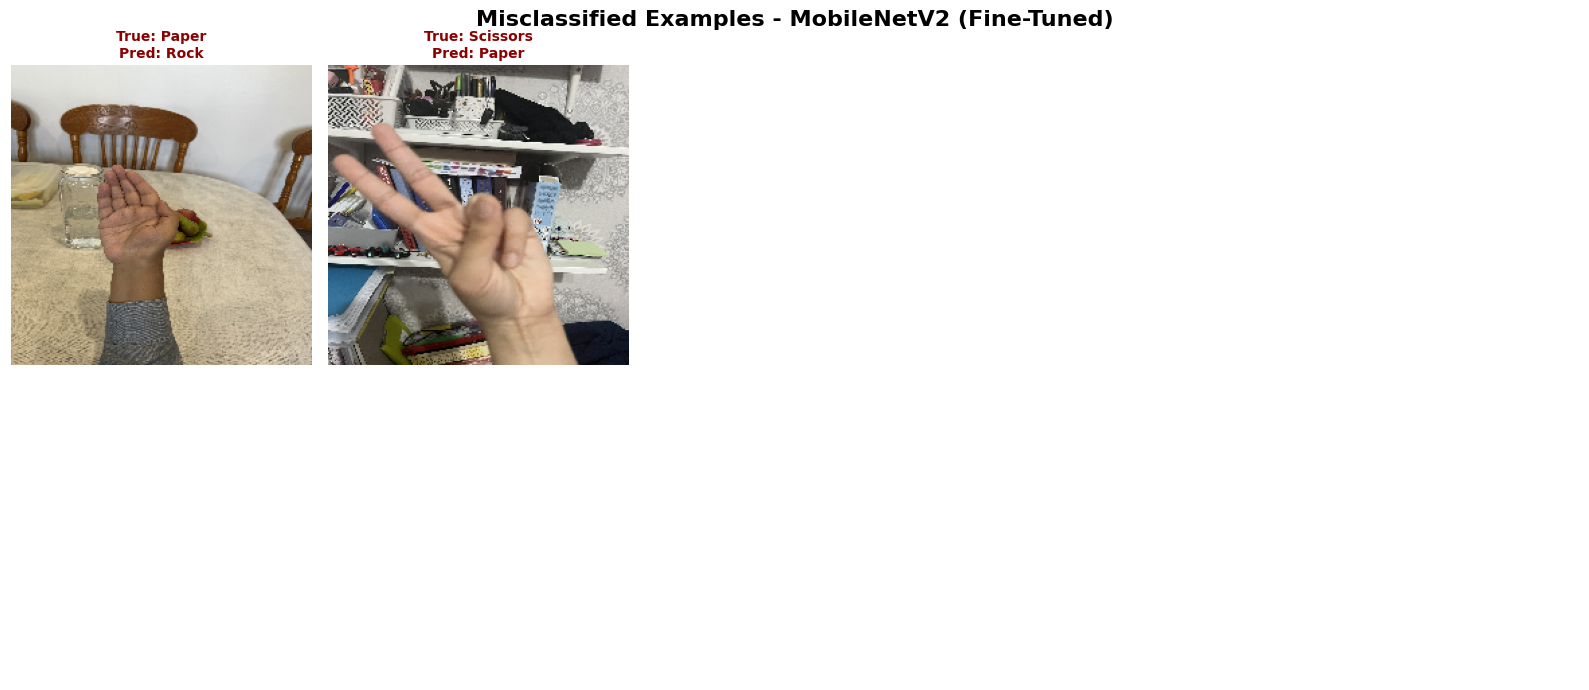

Saved: Results/transfer_misclassified_examples.png


In [32]:
# ============================================
# ERROR ANALYSIS: MISCLASSIFIED EXAMPLES
# ============================================
# visualising which specific images the model gets wrong
# helps understand model weaknesses and failure patterns
# criterion 4: error analysis & improvement strategies

print("=" * 60)
print("ERROR ANALYSIS: MISCLASSIFIED EXAMPLES")
print("=" * 60)

# ============================================
# IDENTIFY MISCLASSIFIED IMAGES
# ============================================

# for cnn model
misclassified_cnn_indices = np.where(np.array(y_true) != np.array(y_pred))[0]
print(f"\nCustom CNN:")
print(f"  Total misclassifications: {len(misclassified_cnn_indices)}")
print(f"  Error rate: {len(misclassified_cnn_indices)/len(y_true)*100:.2f}%")

# for transfer learning (fine-tuned)
misclassified_transfer_indices = np.where(
    np.array(finetuned_y_true) != np.array(finetuned_y_pred)
)[0]
print(f"\nMobileNetV2 (Fine-Tuned):")
print(f"  Total misclassifications: {len(misclassified_transfer_indices)}")
print(f"  Error rate: {len(misclassified_transfer_indices)/len(finetuned_y_true)*100:.2f}%")

# ============================================
# ANALYZE CONFUSION PATTERNS
# ============================================
# which classes get confused with each other?

from collections import Counter

print("\n" + "=" * 60)
print("MOST COMMON CONFUSION PATTERNS (CNN)")
print("=" * 60)

# create list of (true_class, predicted_class) pairs for mistakes
confusion_pairs_cnn = [
    (CLASS_NAMES[y_true[idx]], CLASS_NAMES[y_pred[idx]])
    for idx in misclassified_cnn_indices
]

# find most common confusions
most_common_confusions = Counter(confusion_pairs_cnn).most_common(5)

print("\nTop 5 confusion pairs:")
for (true_class, pred_class), count in most_common_confusions:
    print(f"  {true_class} → {pred_class}: {count} times")
    # explain why this might happen
    if (true_class == 'Rock' and pred_class == 'Paper') or \
       (true_class == 'Paper' and pred_class == 'Rock'):
        print(f"    (Likely due to similar hand positions in certain angles)")
    elif (true_class == 'Scissors' and pred_class == 'Paper') or \
         (true_class == 'Paper' and pred_class == 'Scissors'):
        print(f"    (Extended fingers can look similar)")

# ============================================
# VISUALIZE MISCLASSIFIED EXAMPLES (CNN)
# ============================================

print("\n" + "=" * 60)
print("Generating misclassified examples visualization...")
print("=" * 60)

# select up to 10 misclassified examples
num_examples = min(10, len(misclassified_cnn_indices))
selected_indices = misclassified_cnn_indices[:num_examples]

# create figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Misclassified Examples - Custom CNN Model',
             fontsize=16, fontweight='bold')

for i, idx in enumerate(selected_indices):
    ax = axes[i//5, i%5]

    # load the actual image file
    img_path = test_df.iloc[idx]['filename']
    img = load_img(img_path, target_size=(224, 224))
    ax.imshow(img)

    # get true and predicted labels
    true_label = CLASS_NAMES[y_true[idx]]
    pred_label = CLASS_NAMES[y_pred[idx]]

    # create title showing the error
    # red color indicates error
    title = f"True: {true_label}\nPred: {pred_label}"
    ax.set_title(title, fontsize=10, color='red', fontweight='bold')
    ax.axis('off')

# hide empty subplots if fewer than 10 examples
for i in range(num_examples, 10):
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RPS-AICoursework/Results/cnn_misclassified_examples.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n Saved: Results/cnn_misclassified_examples.png")

# ============================================
# VISUALIZE MISCLASSIFIED EXAMPLES (TRANSFER)
# ============================================

num_examples_transfer = min(10, len(misclassified_transfer_indices))
selected_indices_transfer = misclassified_transfer_indices[:num_examples_transfer]

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Misclassified Examples - MobileNetV2 (Fine-Tuned)',
             fontsize=16, fontweight='bold')

for i, idx in enumerate(selected_indices_transfer):
    ax = axes[i//5, i%5]

    img_path = test_df.iloc[idx]['filename']
    img = load_img(img_path, target_size=(224, 224))
    ax.imshow(img)

    true_label = CLASS_NAMES[finetuned_y_true[idx]]
    pred_label = CLASS_NAMES[finetuned_y_pred[idx]]

    title = f"True: {true_label}\nPred: {pred_label}"
    ax.set_title(title, fontsize=10, color='darkred', fontweight='bold')
    ax.axis('off')

for i in range(num_examples_transfer, 10):
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RPS-AICoursework/Results/transfer_misclassified_examples.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("Saved: Results/transfer_misclassified_examples.png")


In [33]:
# ============================================
# MODEL EFFICIENCY COMPARISON
# ============================================
# comparing model size and inference speed

import time
import os

print("=" * 60)
print("MODEL EFFICIENCY ANALYSIS")
print("=" * 60)

# ===== MODEL SIZE =====
cnn_size = os.path.getsize('/content/drive/MyDrive/RPS-AICoursework/Models/cnn_model.h5') / (1024**2)
frozen_size = os.path.getsize('/content/drive/MyDrive/RPS-AICoursework/Models/transfer_model_frozen.h5') / (1024**2)
finetuned_size = os.path.getsize('/content/drive/MyDrive/RPS-AICoursework/Models/transfer_model_finetuned.h5') / (1024**2)

print(f"\nModel Size:")
print(f"  CNN:          {cnn_size:.2f} MB")
print(f"  Frozen:       {frozen_size:.2f} MB")
print(f"  Fine-tuned:   {finetuned_size:.2f} MB")

# ===== INFERENCE SPEED =====
transfer_test_generator.reset()
test_batch = next(transfer_test_generator)[0][:1]

# CNN speed
start = time.time()
for _ in range(100):
    _ = model.predict(test_batch, verbose=0)
cnn_time = (time.time() - start) / 100 * 1000

# Transfer speed
start = time.time()
for _ in range(100):
    _ = transfer_model.predict(test_batch, verbose=0)
transfer_time = (time.time() - start) / 100 * 1000

print(f"\nInference Speed:")
print(f"  CNN:          {cnn_time:.2f} ms ({1000/cnn_time:.0f} FPS)")
print(f"  Fine-tuned:   {transfer_time:.2f} ms ({1000/transfer_time:.0f} FPS)")

# ===== SUMMARY TABLE =====
efficiency_summary = pd.DataFrame({
    'Model': ['CNN', 'Fine-Tuned'],
    'Accuracy': [test_accuracy, finetuned_test_accuracy],
    'Size (MB)': [cnn_size, finetuned_size],
    'Speed (ms)': [cnn_time, transfer_time],
    'FPS': [1000/cnn_time, 1000/transfer_time]
})

print("\n" + "=" * 60)
print(efficiency_summary.round(2).to_string(index=False))
print("=" * 60)

efficiency_summary.to_csv('/content/drive/MyDrive/RPS-AICoursework/Results/efficiency_summary.csv', index=False)
print("Saved: Results/efficiency_summary.csv")

MODEL EFFICIENCY ANALYSIS

Model Size:
  CNN:          148.13 MB
  Frozen:       11.01 MB
  Fine-tuned:   23.88 MB

Inference Speed:
  CNN:          88.82 ms (11 FPS)
  Fine-tuned:   206.74 ms (5 FPS)

     Model  Accuracy  Size (MB)  Speed (ms)   FPS
       CNN      0.86     148.13       88.82 11.26
Fine-Tuned      0.97      23.88      206.74  4.84
Saved: Results/efficiency_summary.csv
